In [1]:
import sys
import stmpy
import numpy as np
import cancelv3 as cancel
from decimal import *
import matplotlib.pyplot as plt
from sklearn.externals import joblib
import pandas as pd
import scipy.fftpack as fftp
import os
from scipy import signal
import scipy
import matplotlib.pyplot as plt
import time
import gc
%pylab inline

C:\Users\jgoet\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


Populating the interactive namespace from numpy and matplotlib


In [2]:
# folder_loc = '2020-03-13/Chirp Calibration v2/'
# file_loc = '2020-03-13-18-01_chirp2_cal001.dat'
folder_loc = '2020-03-13/Chirp Calibration Lockin/'
file_loc = '2020-03-13-19-41_chirp_lockin_cal001.dat'
dat = np.loadtxt(folder_loc+file_loc,skiprows=76)

for filename in os.listdir(folder_loc):
    if filename == file_loc:
        pass
    try:
        tempdata = np.loadtxt(folder_loc+filename, skiprows=76)
        dat = np.concatenate((dat,tempdata))
        print(filename,end='\r')
    except:
        print('ERROR: ',filename)

In [3]:
plt.style.use('seaborn-darkgrid')

In [4]:
fs = 10000
start = int(38.65*fs)
end = int(2039.7*fs)

cur = dat[start:end,0]
geo = dat[start:end,1]
chirp = dat[start:end,2]
geo_in = dat[start:end,3]
tip = dat[start:end,6]
LIY = dat[start:end,8]

t = linspace(0,len(chirp)/10000,len(chirp))

In [5]:
def fit_cancel(array, n=1):
    t=linspace(0,len(array),len(array))
    fit = polyfit(t,array,n)
    corrective = fit[n]*ones(shape(t))
    for j in arange(n):
        corrective += fit[j]*(t**(n-j))
    return array - corrective

In [6]:
tip_temp = tip-mean(tip)
tip_temp[18697800:] = 2e-10+tip_temp[18697800:]
tip_fit = fit_cancel(tip_temp,n=3)
%reset_selective -f tip_temp

In [7]:
def coef(w,geo,tip,t_array,harmonic,fs=1000):
    
    if w*harmonic >= fs/2:
        return 0 + 0*1j
    
    ref_tip = tip*(np.cos(w*harmonic*2*pi*t_array)-1j*sin(w*harmonic*2*pi*t_array)) 
    ref_geo = geo*(np.cos(w*2*pi*t_array)-1j*sin(w*2*pi*t_array))
    
    sos = signal.butter(10, w/5, 'lowpass', fs=fs, output='sos')
    
    filt_tip = signal.sosfiltfilt(sos,ref_tip)
    filt_geo = signal.sosfiltfilt(sos,ref_geo)
    
    
    lock_tip = average(filt_tip)
    lock_geo = average(filt_geo)
    Z = lock_tip/lock_geo
    
    return Z

prev = 0
harmonics = 10
steps = 10000
loc = linspace(60272,len(t),int(steps/30 -1)).astype('int')
# loc = (change_loc*fs).astype('int')
freq_map = linspace(50,400,len(loc))
fftfreq = fft.fftfreq(int(10000/(freq_map[1]-50)),1/10000)
# print(np.where(absolute(fftfreq-400) <0.1))

C = np.zeros((len(fftfreq),harmonics),dtype='complex128')

for w,point,i in zip(freq_map,loc,arange(len(freq_map))):
    i = i+48
    print(w,end='\r')
    input_wave = geo[prev:point]
    output_wave = cur[prev:point]
    t_split = t[prev:point]
    for j in arange(harmonics):
        C[i,j] = coef(w,input_wave,output_wave,t_split,(j+1),fs = 10000)
        
    prev = point
    
C[int(len(C[:,0])/2):,:] = flip(conj(C[1:int(len(C[:,0])/2)+2]),axis=0)

In [8]:
I_0 = 1e-9
C = C/I_0
C1 = scipy.interpolate.interp1d(fftfreq,C[:,0], kind='linear',fill_value='extrapolate')
C2 = scipy.interpolate.interp1d(fftfreq,C[:,1], kind='linear',fill_value='extrapolate')
C3 = scipy.interpolate.interp1d(fftfreq,C[:,2], kind='linear',fill_value='extrapolate')
C4 = scipy.interpolate.interp1d(fftfreq,C[:,3], kind='linear',fill_value='extrapolate')
C5 = scipy.interpolate.interp1d(fftfreq,C[:,4], kind='linear',fill_value='extrapolate')
C6 = scipy.interpolate.interp1d(fftfreq,C[:,5], kind='linear',fill_value='extrapolate')

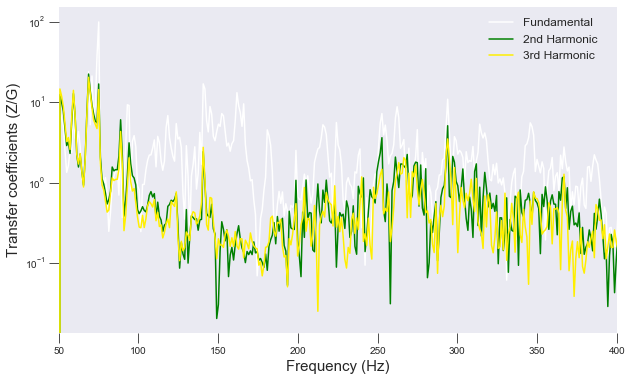

In [9]:
figsize(10,6)

# print(freq_map[1]-50)
# print(fftfreq[379])

fig,ax=subplots(1,1)

semilogy(fftfreq,absolute(C[:,0]),'w',label='Fundamental    ')
semilogy(fftfreq,absolute(C[:,1]),'g',label='2nd Harmonic')
semilogy(fftfreq,absolute(C[:,2]),'#ffef00',label='3rd Harmonic')
xlim(50,400)
tick_params(size= 10)
grid(False)
for spine in ax.spines.values():
    spine.set_edgecolor('white')
xlabel('Frequency (Hz)',size=15)
ylabel('Transfer coefficients (Z/G)',size = 15)
legend(loc=1,fontsize=12)
savefig('2020-3-13 Matrix G-I coefficients')

In [10]:
folder_loc = '2020-03-13/Spec Sweep Noisy 170 v2/'
file_loc = '2020-03-13-21-53_noisy170_spec001.dat'
# folder_loc = '2020-03-13/Spec Sweep Noisy 170/'
# file_loc = '2020-03-13-20-43_spec_noisy1001.dat'

dat_spec = np.loadtxt(folder_loc+file_loc,skiprows=76)

for filename in os.listdir(folder_loc):
    if filename == file_loc:
        pass
    try:
        tempdata = np.loadtxt(folder_loc+filename, skiprows=76)
        dat_spec = np.concatenate((dat_spec,tempdata))
        print(filename,end='\r')
    except:
        print('ERROR: ',filename)

In [11]:
cur = dat_spec[:,0]
geo = dat_spec[:,1]
speaker = dat_spec[:,2]
bias_mod = dat_spec[:,4]
bias = dat_spec[:,5]
Z = dat_spec[:,8]
LIY = dat_spec[:,10]

t = linspace(0,len(cur)/10000,len(cur))
print(len(cur),len(t),shape(dat_spec))

2475000 2475000 (2475000, 11)


324


(0, 25)

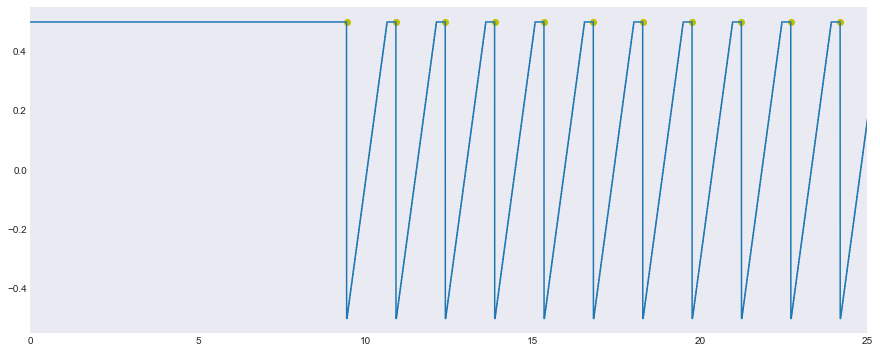

In [12]:
figsize(15,6)
dt = t[1]
grad = np.gradient(bias,dt)
brk_pnt = np.argsort(grad)[:600]
count = 0
for j in brk_pnt:
    if grad[j] < -1000:
        count = count+1
print(count)

brk_pnt = np.argsort(grad)[:count]
brk_pnt = np.sort(brk_pnt)
# print(brk_pnt)
for idx,point in enumerate(brk_pnt):
    temp_pnt = point
    brk_pnt[np.where(absolute(brk_pnt-point)<10)] = 0
    brk_pnt[idx] = point
brk_pnt = np.sort(brk_pnt[brk_pnt != 0])
# brk_pnt = np.append(brk_pnt,-1)
# print(brk_pnt)

plot(t[brk_pnt],bias[brk_pnt],'yo')
plot(t,bias)
grid(False)
# plot(t,grad)
start = 0
xlim(start,start+25)
# ylim(-5009,-4900)

In [13]:
# start = brk_pnt[0]+1
# end = brk_pnt[-1]

# cur_cut = dat_spec[:start,0]
# geo_cut = dat_spec[:start,1]
# speaker_cut = dat_spec[:start,2]
# bias_mod_cut = dat_spec[:start,4]
# bias_cut = dat_spec[:start,5]
# Z_cut = dat_spec[:start,8]
# LIY_cut = dat_spec[:start,10]

# t = linspace(0,len(cur_cut)/10000,len(cur_cut))
# print(len(cur_cut),len(t))

In [14]:
# kappa=-3.273855e10
# delay = 12
# cur_vib = exp(-kappa*(z_vib[delay:]))
# rms_cur = sqrt(mean(cur_cut[10:-delay]**2))
# kappa_test = linspace(-2.4e10,-2.6e10,5000)
# base = 1.0012974925984475e-09
# print(base)
# for k in kappa_test:
#     print(k,end='\r')
#     cur_vib_test = exp(-k*(z_vib[delay:]-mean(z_vib[delay:])))
#     sig = cur_cut[10:-delay]/cur_vib_test
#     rms_sig = sqrt(mean(sig**2))
#     if rms_sig < base:
#         base = rms_sig
#         kappa_final = k
# print(base)
# print(kappa_final)

In [15]:
start = brk_pnt[0]+3
end = brk_pnt[-1]+2

cur_cut = dat_spec[start:end,0]
geo_cut = dat_spec[start:end,1]
speaker_cut = dat_spec[start:end,2]
bias_mod_cut = dat_spec[start:end,4]
bias_cut = dat_spec[start:end,5]
Z_cut = dat_spec[start:end,8]
LIY_cut = dat_spec[start:end,10]

t = linspace(0,len(cur_cut)/10000,len(cur_cut))
print(len(cur_cut),len(t))

2373622 2373622


322 322


(-5, 100)

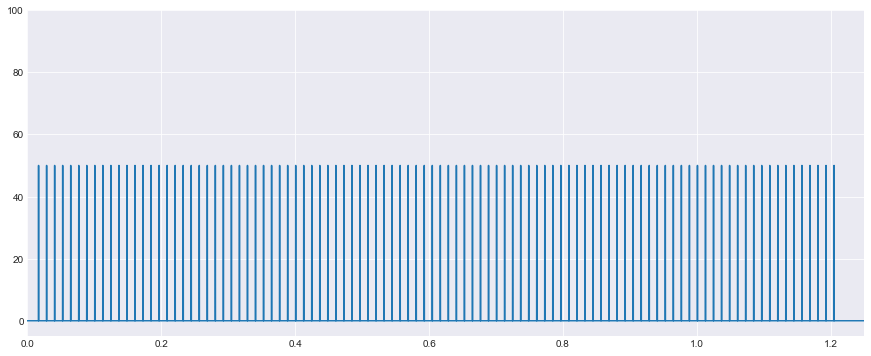

In [16]:
figsize(15,6)
dt = t[1]
grad = np.gradient(bias_cut,dt)
swp_pnt = np.argsort(grad)[:322]
count = 0
for j in swp_pnt:
    if grad[j] < -1000:
        count = count+1
print(count,len(swp_pnt))
swp_pnt = (np.sort(swp_pnt))
swp_pnt = swp_pnt[:322]
plot(t[swp_pnt],grad[swp_pnt],'r.')
# plot(t,bias_cut)
plot(t,grad)
start = 0
xlim(start,start+1.25)
ylim(-5,100)

200
[  168   288   408   528   648   768   888  1008  1128  1248  1368  1488
  1608  1728  1848  1968  2088  2208  2328  2448  2568  2688  2808  2928
  3048  3168  3288  3408  3528  3648  3768  3888  4008  4128  4248  4368
  4488  4608  4728  4848  4968  5088  5208  5328  5448  5568  5688  5808
  5928  6048  6168  6288  6408  6528  6648  6768  6888  7008  7128  7248
  7368  7488  7608  7728  7848  7968  8088  8208  8328  8448  8568  8688
  8808  8928  9048  9168  9288  9408  9528  9648  9768  9888 10008 10128
 10248 10368 10488 10608 10728 10848 10968 11088 11208 11328 11448 11568
 11688 11808 11928 12048 14739]


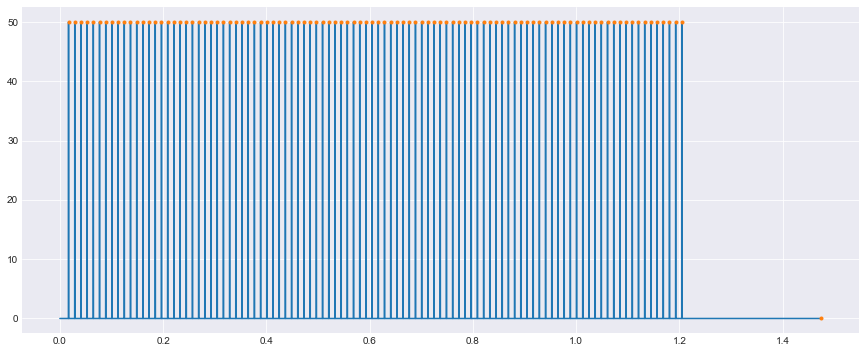

In [17]:
prev = 0
for brk in swp_pnt:
    grad_brk = grad[prev:brk]
    brk_pnt_2 = np.flip(np.argsort(grad_brk))[:200]
    brk_pnt_2 = (np.sort(brk_pnt_2))
    
    count = 0
    for j in brk_pnt_2:
        if grad_brk[j] > 20:
            count = count+1
    print(count)
#     plot(t[prev:brk],grad_brk)
#     plot(t[brk_pnt_2],grad_brk[brk_pnt_2],'.')
#     xlim(0,0.2)
    break

step_pnt = np.flip(np.argsort(grad_brk))[:200]
step_pnt = -np.sort(-step_pnt)
# print(brk_pnt)
for idx,point in enumerate(step_pnt):
    temp_pnt = point
    step_pnt[np.where(absolute(step_pnt-point)<10)] = 0
    step_pnt[idx] = point
step_pnt = np.sort(step_pnt[step_pnt != 0])
step_pnt = np.append(step_pnt,len(grad_brk)-1)
plot(t[prev:brk],grad_brk)
plot(t[step_pnt],grad_brk[step_pnt],'.')
print(step_pnt)

In [18]:
prev = 0 

I_n = np.zeros(len(step_pnt))
reps = np.zeros(len(step_pnt))
for idx,point in enumerate(step_pnt):
    I_n[idx] = mean(cur_cut[prev:point])
    reps[idx] = point-prev
    prev = point
reps[-1] = reps[-1] +1
# print(len(I_n),reps.astype('int'))
# print(I_n)
I_n = repeat(I_n,reps.astype('int'))

print(len(cur_cut[:brk]),len(I_n),I_n[0])

14740 14740 -9.164837949404763e-10


(0, 1.2)

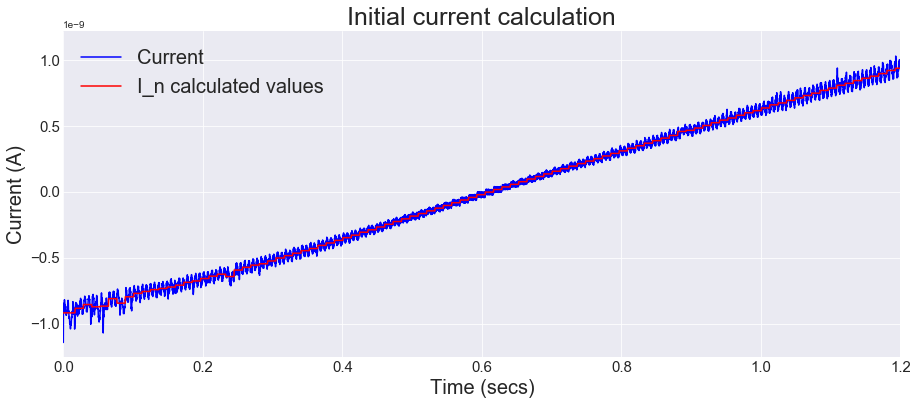

In [19]:
plot(t[:brk],cur_cut[:brk],'b',label='Current')
plot(t[:brk],I_n,'r',label='I_n calculated values')
# color= 'w'
tick_params(labelsize=15)
title('Initial current calculation',size=25)
xlabel('Time (secs)',size=20)
ylabel('Current (A)',size=20)
leg = legend(loc=2, fontsize = 20,fancybox=True, framealpha=0)
xlim(0,1.2)

In [20]:
G_sweep = fft.fft(geo_cut)
omega = fft.fftfreq(len(geo_cut),1/10000)
G_sweep = scipy.interpolate.interp1d(omega,G_sweep,kind='linear',fill_value='extrapolate')

In [21]:
cur_swp_omega = C1(omega)*G_sweep(omega) + C2(omega/2)*G_sweep(omega/2) + C4(omega/4)*G_sweep(omega/4)  
cur_swp_vib = fft.ifft(cur_swp_omega)

In [22]:
delay = 12
cur_sig_brk = cur_cut[delay:brk]-I_n[delay:]*cur_swp_vib[:brk-delay]

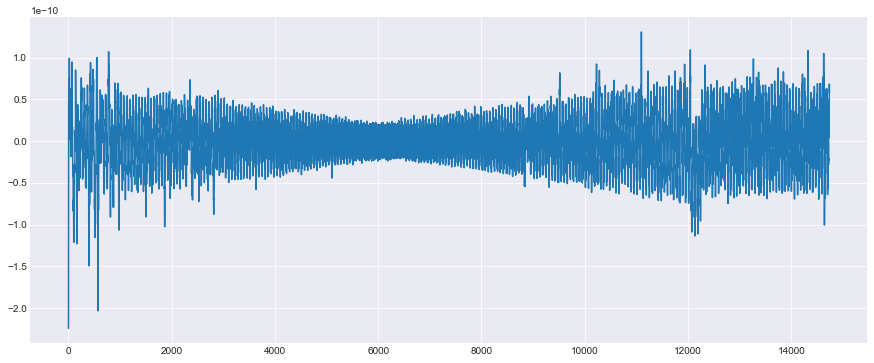

In [23]:
plot(cur_cut[:brk]-I_n)

C:\Users\jgoet\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  """Entry point for launching an IPython kernel.
C:\Users\jgoet\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(0, 1.2)

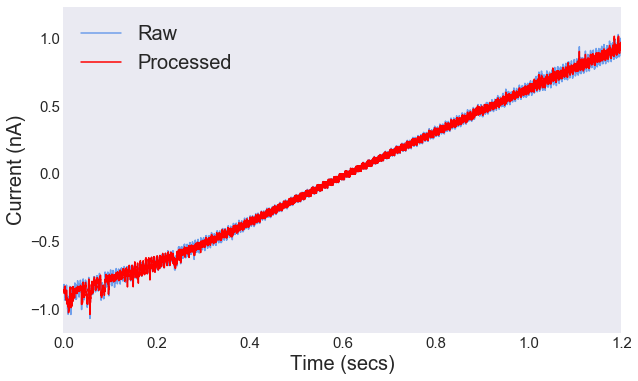

In [24]:
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)
plt.style.use('seaborn-darkgrid')
delay=12
figsize(10,6)
# cur_swp_vib = exp(-kappa_final*(z_swp_vib))
plot(t[delay:brk],1e9*cur_cut[delay:brk],'#6d9eeb',label='Raw')
# plot(t[:brk-delay],cur_sig_brk)
plot(t[delay:brk],1e9*cur_sig_brk,'r',label='Processed')
grid(False)
tick_params(labelsize=15)
# title('Initial current calculation',size=25)
xlabel('Time (secs)',size=20)
ylabel('Current (nA)',size=20)
leg = legend(loc=2, fontsize = 20,fancybox=True, framealpha=0)
xlim(0,1.2)
# ylim(0.6,1.1)
# savefig('2020-03-13 voltage sweep matrix cancellation',transparent=True)

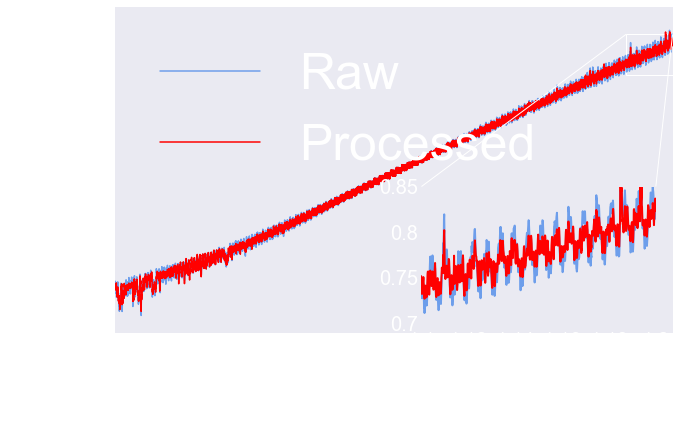

In [25]:
fig, ax1 = plt.subplots()
figsize(30,25)
# T_E = np.arange(1,max(T)+1,1)
# The data.
ax1.plot(t[delay:brk], 1e9*cur_cut[delay:brk], c='#6d9eeb', label='Raw')
# The Einstein fit.
ax1.plot(t[delay:brk],1e9*cur_sig_brk,'r',label='Processed')
ax1.tick_params(color='w')
ax1.set_xlabel('Time/Voltage',size=50,color='w')
ax1.set_ylabel('Current (nA)',size=50,color='w')
# ax1.set_xlabel(r'$T\,/\mathrm{K}$')
# ax1.set_ylabel(r'$C_p\,/\mathrm{J\,K^{-1}\,mol^{-1}}$')
leg = ax1.legend(loc=0,fontsize=50)
# leg = legend(loc=1,fontsize = 36,fancybox=True, framealpha=0)

for text in leg.get_texts():
    plt.setp(text, color = 'w')
for spine in ax1.spines.values():
    spine.set_edgecolor('white')
ax1.grid(False)
# Create a set of inset Axes: these should fill the bounding box allocated to
# them.
ax2 = plt.axes([0,0,1,1])
# Manually set the position and relative size of the inset axes within ax1
ip = InsetPosition(ax1, [0.55,0.03,0.42,0.42])
ax2.set_axes_locator(ip)
# Mark the region corresponding to the inset axes on ax1 and draw lines
# in grey linking the two axes.
mark_inset(ax1, ax2, loc1=1, loc2=2, fc="none", ec='w')

# The data: only display for low temperature in the inset figure.
# Tmax = max(T_D)
ax2.plot(t[delay:brk], 1e9*cur_cut[delay:brk],c='#6d9eeb', label='Raw',linewidth=2)
# The Einstein fit (not very good at low T).
ax2.plot(t[delay:brk], 1e9*cur_sig_brk,'r',label='Processed',linewidth=2)
ax2.set_xlim(1.1,1.2)
ax2.grid(False)
ax2.set_ylim(0.7,1)

# The Debye fit.
# ax2.plot(T_D, CV_D, c='r', lw=2, alpha=0.5, label='Debye model')
# ax2.legend(loc=0)
for spine in ax2.spines.values():
    spine.set_edgecolor('white')
# Some ad hoc tweaks.
ax1.set_ylim(-1.2,1.2)
ax1.set_xlim(0,1.2)
ax1.set_yticklabels(around(ax1.get_yticks(),3),color='w',size=30)
ax1.set_xticklabels(around(ax1.get_xticks(),3),color='w',size=30)
ax2.set_yticklabels(around(ax2.get_yticks(),3),color='w',size=20)
ax2.set_xticklabels(around(ax2.get_xticks(),3),color='w',size=20)
ax2.tick_params(axis='x', which='major', pad=8,color='w')
savefig('2020-03-13 Sweep cancellation',transparent = True)
plt.show()

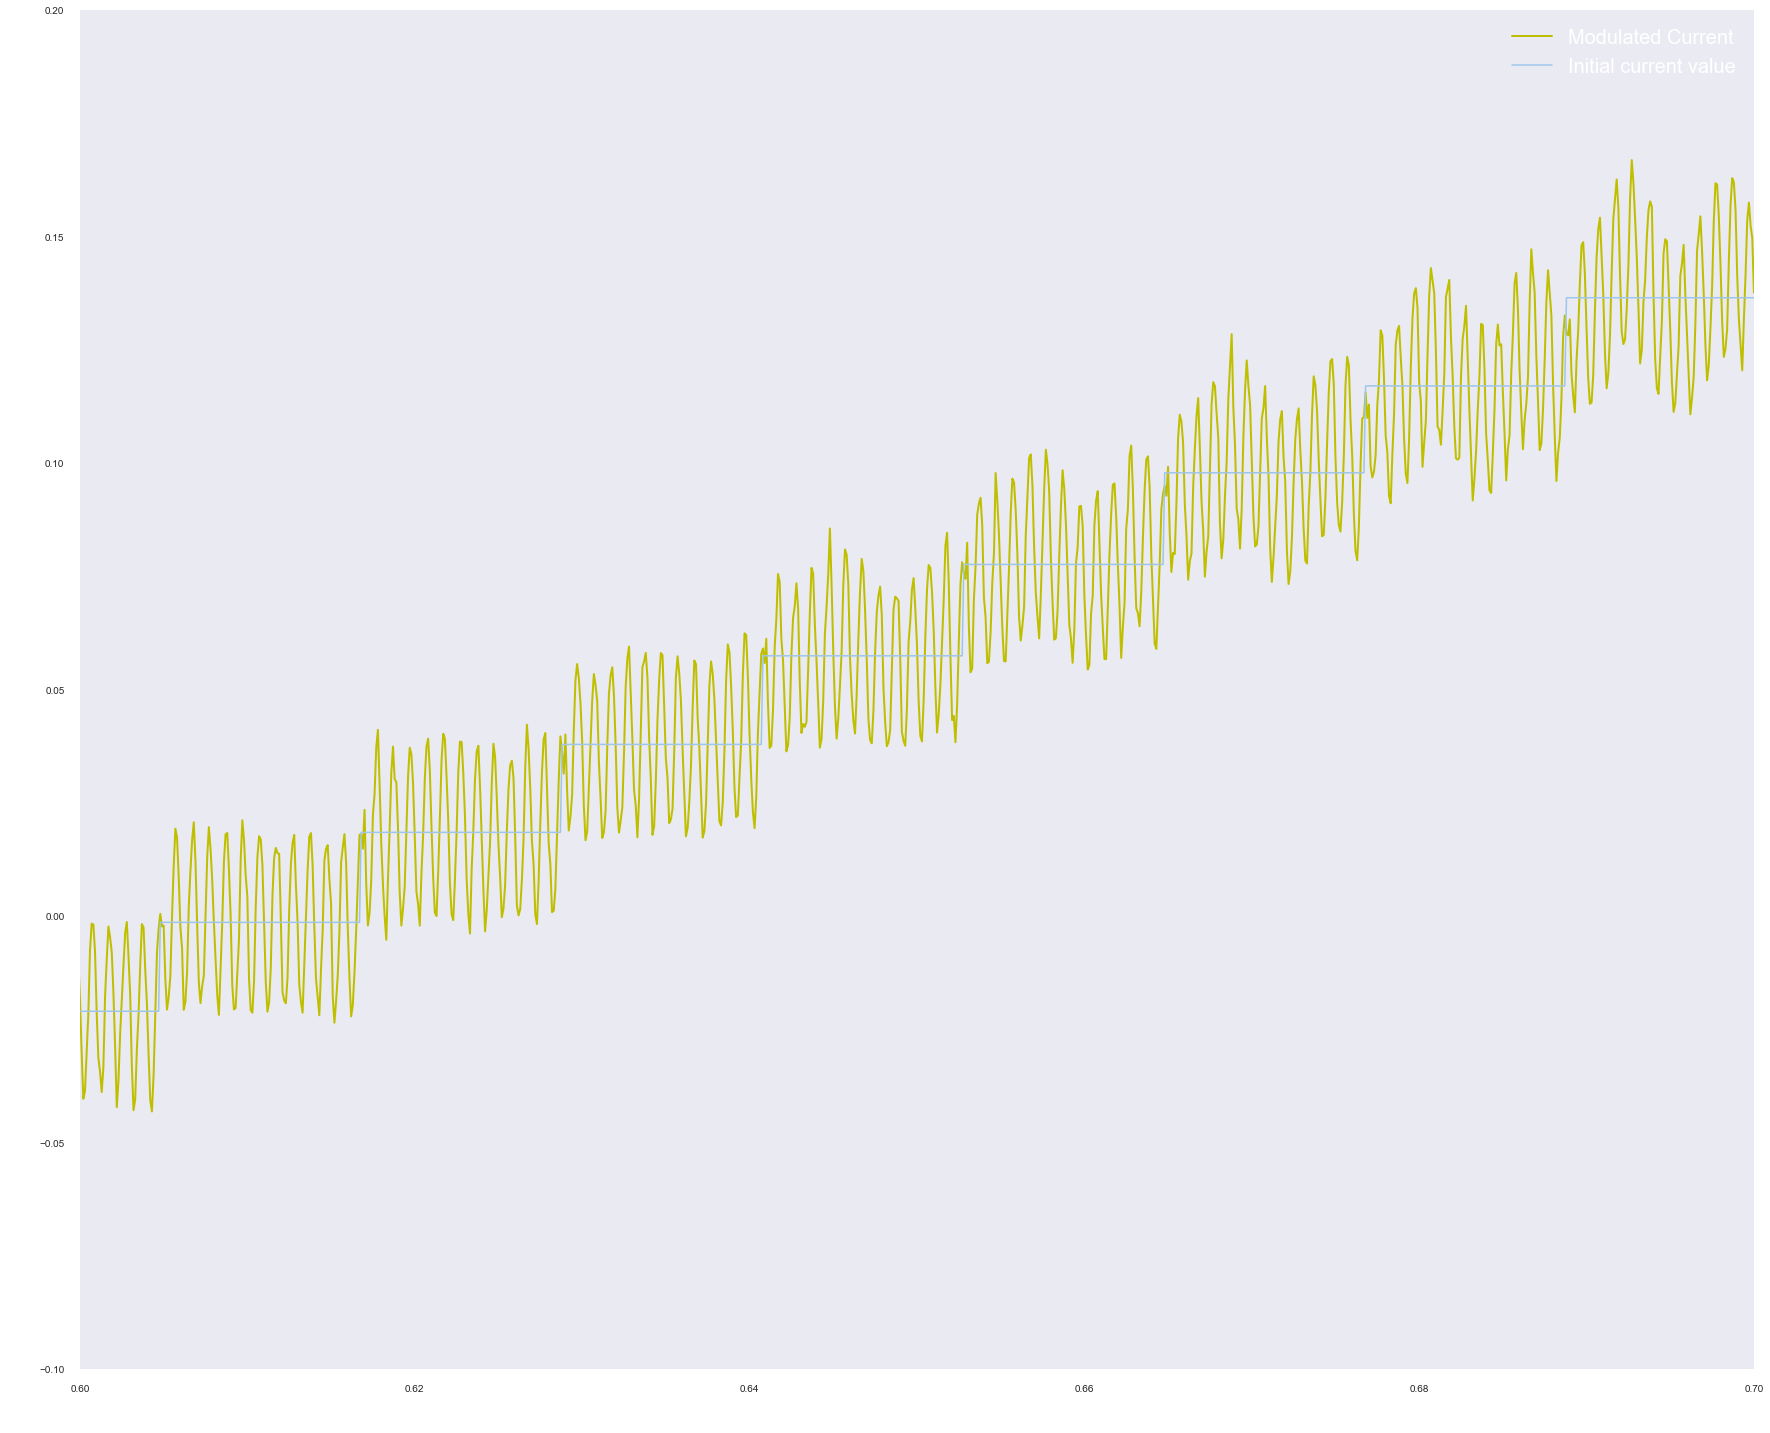

In [26]:
fig,ax = subplots(1,1)
figsize(10,8)
plot(t[delay:brk], 1e9*cur_cut[delay:brk],c='y', label='Modulated Current',linewidth=2)
plot(t[delay:brk],1e9*I_n[delay:],color='#9fc5e8',label='Initial current value')
# The Einstein fit (not very good at low T).
# plot(t[delay:brk], 1e9*cur_sig_brk,'r',label='Processed',linewidth=4)
grid(False)
leg = legend(loc=0,fontsize=20)
# leg = legend(loc=1,fontsize = 36,fancybox=True, framealpha=0)

for text in leg.get_texts():
    plt.setp(text, color = 'w')
for spine in ax1.spines.values():
    spine.set_edgecolor('white')
tick_params(size=12,color='w')
# ax.set_yticklabels(,size=20,color='w')
xlabel('Time/Voltage',size=30,color='w')
ylabel('Current (pA)',size=30,color='w')
xlim(0.6,0.7)
ylim(-0.1,0.2)
savefig('Spec im not zoom',transparent=True)

In [27]:
rms_raw = sqrt(mean((1e9*cur_cut[delay:brk])**2))
rms_proc = sqrt(mean((1e9*cur_sig_brk)**2))
print(rms_proc/rms_raw)

(0.9997094935301035+8.931836541732964e-20j)


In [28]:
wave = cos(170*2*pi*t[delay:brk])+ 1j*sin(170*2*pi*t[delay:brk])
lock_raw = cur_cut[delay:brk]*wave
lock_proc = cur_sig_brk*wave
sos = signal.butter(10,40,'lowpass',fs=fs,output='sos')
filt_raw = signal.sosfiltfilt(sos,lock_raw)
filt_proc = signal.sosfiltfilt(sos,lock_proc)
#     sos = signal.butter(10, w/5, 'lowpass', fs=fs, output='sos')
    
#     filt_tip = signal.sosfiltfilt(sos,ref_tip)
r = average(filt_raw)
p = average(filt_proc)
print(r,p)
print(100-100*absolute(p/r))

(-3.695125179765459e-12-3.0949070317888483e-12j) (-3.770665013705659e-12+8.044966413060688e-14j)
21.752631330530207


(0, 600)

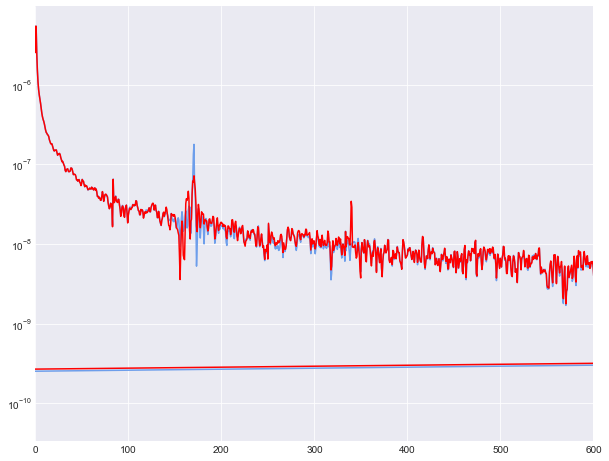

In [29]:
raw_fft = fft.fft(cur_cut[delay:brk])
proc_fft = fft.fft(cur_sig_brk)
frq = np.fft.fftfreq(len(cur_sig_brk),1/10000)
semilogy(frq,absolute(raw_fft),'#6d9eeb',label='Raw')
semilogy(frq,absolute(proc_fft),'r',label='Processed')
xlim(0,600)

In [30]:
print(frq[250:260])
print(absolute(raw_fft[250:253]))
print(absolute(proc_fft[250:253]))

[169.74470397 170.42368278 171.1026616  171.78164041 172.46061923
 173.13959804 173.81857686 174.49755568 175.17653449 175.85551331]
[1.32608076e-07 1.78830797e-07 5.13767695e-08]
[5.97988631e-08 7.19582343e-08 5.92376504e-08]
